In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet 
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [5]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (300, 300)

# Vocabulary size
# VOCAB_SIZE = 30527
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 30

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 768

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
pip install transformers

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 34.1 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
     |████████████████████████████████| 895 kB 46.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
from transformers import AutoTokenizer, AutoModel
from transformers import PreTrainedTokenizer

import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for
# sentences = ['This framework generates embeddings for each input sentence',
#              'Sentences are passed as a list of string.',
#              'The quick brown fox jumps over the lazy dog.']

#Load AutoModel from huggingface model repository
# token_model = PreTrainedTokenizer(model_max_length = VOCAB_SIZE, padding_side = 'right', truncation_side = 'right', 
#                                   bos_token = '<start>', eos_token = '<end>', pad_token ='<pad>')


tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
# model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2",output_hidden_states=True)

token_ids = tokenizer.encode("This is a sample text to test the tokenizer.",padding='max_length', truncation=True, max_length=SEQ_LENGTH)
print( token_ids )
# print( tokenizer.convert_ids_to_tokens( token_ids ) )
print(tokenizer.decode(token_ids))
#Tokenize sentences
def create_embeddings(sentences):
    encoded_input = tokenizer(sentences, padding='max_length', truncation=True, max_length=SEQ_LENGTH, return_tensors='pt',)

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    return model_output
    #Perform pooling. In this case, mean pooling
    # sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    # return sentence_embeddings

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

[0, 2027, 2007, 1041, 7103, 3797, 2004, 3235, 2000, 19208, 17633, 1016, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<s> this is a sample text to test the tokenizer. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## Embedding Matrix

In [ ]:
# def get_word_idx(sent: str, word: str):
#     return sent.split(" ").index(word)
 
 
def get_hidden_states(encoded, token_ids_word, output):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
      Select only those subword token outputs that belong to our word of interest
      and average them."""
    
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)
 
 
def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
      that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer(sent, padding=True, truncation=True, max_length=SEQ_LENGTH, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded)
    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    sentence_emb = []
    # get all token idxs that belong to the word of interest
    for i in idx:
        token_ids_word = np.where(np.array(encoded.word_ids()) == i)
        sentence_emb.append(get_hidden_states(encoded, token_ids_word, output).numpy())

    return sentence_emb
 
def get_sent_embedding(sent,word = None,layers=None):
    # Use last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    #  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    #  model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

    #  sent = "I like cookies ." 
    # idx = get_word_idx(sent, word)
    sent = sent.strip()
    idx = [i for i in range(len(sent.split()))]

    sent_embedding = get_word_vector(sent, idx, tokenizer, model, layers)

    return sent_embedding 
 

In [ ]:
embedding_matrix = np.zeros((VOCAB_SIZE,EMBED_DIM))

In [ ]:
embedding_matrix.shape

(30527, 768)

In [ ]:
def update_embedding(data_list):
    tot = 0
    for sent in data_list:
        sent_embedding = get_sent_embedding(sent)
        cnt = 0
        for word in sent.split():
            rel = tokenizer.encode(word)
            for r in rel[1:-1]:
                # print(embedding_matrix[r])
                embedding_matrix[r] += sent_embedding[cnt]
                # print(embedding_matrix[r])
            cnt += 1
        if tot%1000 == 0:
            print(tot)
        tot += 1

In [ ]:
# update_embedding(text_data)

In [ ]:
# import numpy as np
# np.save('embedding_matrix_numpy', embedding_matrix)

In [ ]:
# import pickle
# with open('embedding_matrix.pkl', 'wb') as handle:
#     pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
word_count = {}

def countWords(data_list):

  for sent in data_list:
    for word in sent.split():
      rel = tokenizer.encode(word)
      for r in rel[1:-1]:
        if r in word_count:
          word_count[r] += 1
        else:
          word_count[r] = 1

In [ ]:
countWords(text_data)

In [ ]:
# word_count

In [ ]:
# for i in range(VOCAB_SIZE):
#     # word = tokenizer.convert_ids_to_tokens(i)
#     if i in word_count:
#         embedding_matrix[i] = embedding_matrix[i] / word_count[i]

In [ ]:
# for i in range(VOCAB_SIZE):
#     # word = tokenizer.convert_ids_to_tokens(i)
#     if embedding_matrix.any() == np.NINF:
#        print('H')

## Load Embedding

In [7]:
import numpy as np
# embedding_matrix = np.load('/content/drive/MyDrive/BTP6Sem/Copy of final_embedding_matrix_numpy.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Internship/Copy of final_embedding_matrix_numpy.npy')

In [ ]:
# embedding_matrix[2027]

In [ ]:
# pad = np.zeros((2,EMBED_DIM))
# embedding_matrix = np.concatenate((pad,embedding_matrix))

In [8]:
embedding_matrix.sum()

nan

In [9]:
var = np.isnan(embedding_matrix)

In [10]:
var2 = np.isneginf(embedding_matrix)

In [11]:
embedding_matrix = np.nan_to_num(embedding_matrix)

In [12]:
var = np.isnan(embedding_matrix)

In [ ]:
# embedding_matrix[2027]

In [ ]:
for i in var:
  for j in i:
    if(j): print("hai")

In [ ]:
embedding_matrix.shape

(30527, 768)

In [ ]:
# for i in range(VOCAB_SIZE):
#     # word = tokenizer.convert_ids_to_tokens(i)
#     if i in word_count:
#       if word_count[i] == 0:
#         print(i)

In [ ]:
# import numpy as np
# np.save('final_embedding_matrix_numpy', embedding_matrix)

In [ ]:
# import pickle
# with open('final_embedding_matrix.pkl', 'wb') as handle:
#     pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# import pickle
# with open('word_count.pkl', 'wb') as handle:
#     pickle.dump(word_count, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# newbedding = np.zeros((VOCAB_SIZE,EMBED_DIM))

In [13]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                # caption = "<s> " + caption.strip() + " </s>"
                caption = caption.strip()
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

In [14]:
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

In [15]:
x = [tokenizer.encode(sent) for sent in text_data]
vocsize = set()
for i in x:
    vocsize = vocsize.union(set(i))

vocsize.add(1)

In [16]:
tk_list = []
for i in range(30527):
    if i in vocsize:
        tk_list.append(i)

In [17]:
print(len(tk_list))

7362


In [18]:
tk_ct = {}
ct_tk = {}

ct = 0
for i in tk_list:
    tk_ct[i] = ct
    ct_tk[ct] = i
    ct += 1

In [19]:
new_embMat = np.zeros((VOCAB_SIZE, EMBED_DIM))

for i in range(len(tk_list)):
    new_embMat[i] = embedding_matrix[ct_tk[i]]

In [20]:
print(new_embMat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
# def load_captions_data(filename):
#     """Loads captions (text) data and maps them to corresponding images.

#     Args:
#         filename: Path to the text file containing caption data.

#     Returns: 
#         caption_mapping: Dictionary mapping image names and the corresponding captions
#         text_data: List containing all the available captions
#     """

#     with open(filename) as caption_file:
#         caption_data = caption_file.readlines()
#         caption_mapping = {}
#         text_data = []
#         images_to_skip = set()

#         for line in caption_data:
#             line = line.rstrip("\n")
#             # Image name and captions are separated using a tab
#             img_name, caption = line.split("\t")

#             # Each image is repeated five times for the five different captions.
#             # Each image name has a suffix `#(caption_number)`
#             img_name = img_name.split("#")[0]
#             img_name = os.path.join(IMAGES_PATH, img_name.strip())

#             # We will remove caption that are either too short to too long
#             tokens = caption.strip().split()

#             if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
#                 images_to_skip.add(img_name)
#                 continue

#             if img_name.endswith("jpg") and img_name not in images_to_skip:
#                 # We will add a start and an end token to each caption
#                 # caption = "<s> " + caption.strip() + " </s>"
#                 caption = caption.strip()
#                 text_data.append(caption)

#                 if img_name in caption_mapping:
#                     caption_mapping[img_name].append(caption)
#                 else:
#                     caption_mapping[img_name] = [caption]

#         for img_name in images_to_skip:
#             if img_name in caption_mapping:
#                 del caption_mapping[img_name]

#         return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: [tf.constant([tk_ct[i] for i in tokenizer.encode(sent,padding='max_length', truncation=True, max_length=SEQ_LENGTH)], dtype=tf.int64) for sent in caption_data[img_name]] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: [tf.constant([tk_ct[i] for i in tokenizer.encode(sent,padding='max_length', truncation=True, max_length=SEQ_LENGTH)], dtype=tf.int64) for sent in caption_data[img_name]] for img_name in all_images[train_size:] 
    }

    val_no_tok = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }
    # 4. Return the splits
    return training_data, validation_data, val_no_tok


# Load the dataset
# captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data, val_no_tok = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6221
Number of validation samples:  1556


## Continued

In [ ]:

# def custom_standardization(input_string):
#     lowercase = tf.strings.lower(input_string)
#     return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


# strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
# strip_chars = strip_chars.replace("<", "")
# strip_chars = strip_chars.replace(">", "")

# vectorization = TextVectorization(
#     max_tokens=VOCAB_SIZE,
#     output_mode="int",
#     output_sequence_length=SEQ_LENGTH,
#     standardize=None,
#     vocabulary = [tokenizer.convert_ids_to_tokens(i) for i in range(VOCAB_SIZE-2)]
# )
# vectorization.adapt(text_data)

# Data augmentation for image data


In [ ]:
# vectorization(["<s>"])[:, :-1]

In [22]:
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [23]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_input(img_path, captions=None):
    if captions is None:
        return decode_and_resize(img_path)
    return decode_and_resize(img_path), captions

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [24]:
def get_cnn_model():
    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    # for layer in base_model.layers[:-5]:
    #     layer.trainable = False
    base_model.trainable = False

    # base_model_out = base_model.layers[-20].output
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    
    return cnn_model

In [25]:
test_model = get_cnn_model()
# test_model.summary()

24289280/24274472 [==============================] - 0s 0us/step


In [26]:
test_model.output.shape

TensorShape([None, 100, 1280])

In [2]:
# def get_cnn_model():
#     base_model = tf.keras.applications.EfficientNetV2B0(
#         input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
#     )
#     # We freeze our feature extractor
#     for layer in base_model.layers[:-5]:
#         layer.trainable = False
#     # base_model.trainable = False
#     base_model_out = base_model.output
#     base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
#     cnn_model = keras.models.Model(base_model.input, base_model_out)
#     return cnn_model

# from tensorflow.keras.layers import Conv2D,Activation
# from tensorflow.keras.layers import concatenate,Dropout,add

# def residual_module(layer_in, n_filters):
#     merge_input = layer_in
#     # check if the number of filters needs to be increase, assumes channels last format
#     if layer_in.shape[-1] != n_filters:
#       merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu')(layer_in)
#     # conv1
#     conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
#     # conv2
#     conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
#     # add filters, assumes filters/channels last
#     layer_out = add([conv2, merge_input])
#     # activation function
#     layer_out = Activation('relu')(layer_out)
#     return layer_out

ENC_LAYERS = 4

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # self.token_embeddings = layers.Embedding(
        #     input_dim=vocab_size, output_dim=embed_dim
        # )
        # self.position_embeddings = layers.Embedding(
        #     input_dim=sequence_length, output_dim=embed_dim
        # )

        self.token_embeddings = tf.keras.layers.Embedding(VOCAB_SIZE, new_embMat.shape[1], 
                                               embeddings_initializer=tf.keras.initializers.Constant(new_embMat), 
                                               trainable=True,
                                               mask_zero=True)
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        # self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.2
        )
        # self.layernorm_1 = layers.LayerNormalization()
        # self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_1 = layers.Dropout(rate=0.2)
        
        self.dense_1 = layers.Dense(embed_dim, activation=layers.PReLU())
        self.dense_2 = layers.Dense(dense_dim, activation=layers.PReLU())
        # self.cnn_1 = residual_module
        # self.dense_2 = layers.Dense(embed_dim, activation="relu")
        self.ffn_2 = layers.Dense(embed_dim)

    def call(self, inputs, training, mask=None):
        # inputs = self.cnn_1(inputs,1024)

        # inputs = self.layernorm_1(inputs)
        # inputs = self.dense_1(inputs)
        # inputs = self.dropout_1(inputs)
        # inputs = self.dense_2(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        # out_1 = self.layernorm_2(inputs + attention_output_1, training=training)
        att_1 = self.dense_1(attention_output_1)

        out_1 = self.dense_2(attention_output_1)
        out_1 = self.ffn_2(out_1)
        out_1 = self.dropout_1(out_1, training=training)
        out_2 = self.layernorm_3(out_1 + att_1, training=training)

        return out_2


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, n_layers, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.n_layers = n_layers
        # self.embedding = PositionalEmbedding(
        #     embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        # )
        self.dense_1 = layers.Dense(embed_dim, activation=layers.PReLU())
        self.dropout = layers.Dropout(rate=0.1)
        self.enc_layers = [EncoderLayer(embed_dim, dense_dim, num_heads) for _ in range(n_layers)]
        # self.lstm_layers = [LSTM(dense_dim,dropout = 0.3,return_sequences=True) for _ in range(2*n_layers)]

    def call(self, inputs, training, mask=None):

        # outputs = self.dense_1(inputs)

        outputs = self.dropout(inputs,training=training)

        enc_outs = []
        for i in range(self.n_layers):
            inputs = self.enc_layers[i](inputs, training, mask)
            enc_outs.append(inputs)
        # for i in range(2*self.n_layers):
        #     inputs = self.lstm_layers[i](inputs)
        return inputs, enc_outs

class DecoderLayers(layers.Layer):
    def __init__(self, num_layers, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.fc_alphas = [tf.keras.layers.Dense(embed_dim) for i in range(num_layers)]

        self.ffn_layer_1 = layers.Dense(ff_dim, activation=layers.PReLU())
        self.ffn_layer_2 = layers.Dense(embed_dim,activation = layers.PReLU())

        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-6)
        # self.layernorm_3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout_1 = layers.Dropout(0.2)
        self.dropout_2 = layers.Dropout(0.2)
        self.dropout_3 = layers.Dropout(0.2)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, combined_mask, padding_mask):

        N = len(encoder_outputs)
        assert len(encoder_outputs) == len(self.fc_alphas)


        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        # out_1 = self.layernorm_1(inputs + attention_output_1, training=training)
        mesh_outs = []
        for i in range(N):

            attention_output_2 = self.attention_2(
                query=attention_output_1,
                value=encoder_outputs[i],
                key=encoder_outputs[i],
                attention_mask=padding_mask,
                training=training,
            )
            alpha_out = tf.nn.sigmoid(
                self.fc_alphas[i](tf.concat([attention_output_1, attention_output_2], axis=-1))
            )
            mesh_outs.append(alpha_out * attention_output_2)
        
        mesh_out = tf.add_n(mesh_outs) / tf.math.sqrt(float(N))
        mesh_out = self.dropout_1(mesh_out, training=training)

        mesh_out = self.layernorm_1(mesh_out + attention_output_1, training=training)

        ffn_out = self.ffn_layer_1(mesh_out)
        ffn_out = self.dropout_2(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_2(ffn_out + mesh_out, training=training)
        ffn_out = self.dropout_3(ffn_out, training=training)
        return ffn_out



class TransformerDecoderBlock(layers.Layer):
    def __init__(self, n_layers, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayers(ENC_LAYERS,embed_dim, ff_dim, num_heads) for _ in range(n_layers)]

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )

        # self.embedding = tf.keras.layers.Embedding(VOCAB_SIZE, embedding_matrix.shape[1], 
        #                                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
        #                                        trainable=True,
        #                                        mask_zero=True)
        
        # self.position_embeddings = layers.Embedding(
        #     input_dim=SEQ_LENGTH, output_dim=embed_dim
        # )

        # self.embedding = self.wembedding + self.position_embeddings

        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout = layers.Dropout(0.2)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
        
        outputs = self.dropout(inputs, training = training)
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs, encoder_outputs, training, combined_mask, padding_mask)

        preds = self.out(outputs)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        # tf.print(tf.argmax(y_pred, axis=2))
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        # tf.print(tf.shape(accuracy))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out, all_encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        # mask = tf.math.not_equal(batch_seq_inp, 1)
        # encoder_out = self.encoder(batch_seq_inp, img_embed, training=training, mask=mask)
        mask = tf.math.not_equal(batch_seq_true, 1)
        batch_seq_pred = self.decoder(
            batch_seq_inp, all_encoder_out, training=training, mask=mask
        )# change
        # tf.print(tf.shape(batch_seq_true))

        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0  
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )# change

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}# change

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )# change

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}# change

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(n_layers = ENC_LAYERS,embed_dim=EMBED_DIM, dense_dim=2048, num_heads=4)
decoder = TransformerDecoderBlock(n_layers = 4,embed_dim=EMBED_DIM, ff_dim=2048, num_heads=4)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

NameError: ignored

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc",patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)# change

In [29]:
# embedding_matrix.shape[1]

In [ ]:
# Fit the model
r = caption_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset,
        callbacks=[early_stopping],
    )

Epoch 1/30
98/98 [==============================] - 1376s 13s/step - loss: 23.9958 - acc: 0.2123 - val_loss: 18.4516 - val_acc: 0.3473
Epoch 2/30
 2/98 [..............................] - ETA: 19:25 - loss: 17.8627 - acc: 0.3551

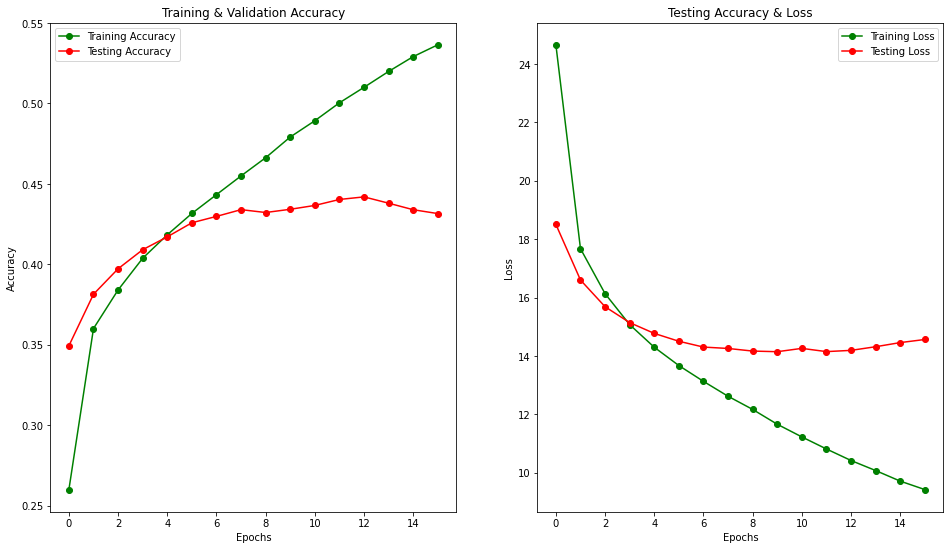

In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(16)]
fig , ax = plt.subplots(1,2)
train_acc = r.history['acc']
train_loss = r.history['loss']
val_acc = r.history['val_acc']
val_loss = r.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

# Save


In [ ]:
# caption_model.build((None, 224, 224, 3))

In [ ]:
# caption_model.summary()

In [ ]:
# input_shape=(224, 224, 3)
# model=caption_model(input_shape)

In [ ]:
# caption_model.compute_output_shape(input_shape=(None, 224, 224, 3))

In [ ]:
# new_model = ImageCaptioningModel(
#     cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
# )

In [ ]:
caption_model.save_weights('/content/drive/MyDrive/sem6btp/models/ImageCap_MeshedMem_EfficientNetV2B0_4x4_v1')

In [ ]:
# caption_model.load_weights('/content/drive/MyDrive/sem6btp/models/ImageCap_MeshedMem_EfficientNetV2B0_v1')

In [ ]:
# new_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)# change
# new_model.fit(
#         train_dataset,
#         epochs=EPOCHS,
#         validation_data=valid_dataset,
#         callbacks=[early_stopping],
#     )

In [ ]:
# new_model.summary()

In [ ]:
# caption_model.save('ImageCapEfficientNetB0.pb')

# Score

In [ ]:
 pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-pmrbh9wd
  Running command git clone -q https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-pmrbh9wd
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312215 sha256=cf2b0b3f71f3e60bc0a629dc1899c860cf312006d7215699a14a1f7f7f3950b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-k0oplf5p/wheels/6f/c9/51/e266f0496048c16686e133d8e33644d692931a356bfb372aae
Successfully built pycocoevalcap


In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

def scorefunc(ref, hypo):
    scorers = [
        (Bleu(4),["Bleu_1","Bleu_2","Bleu_3","Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(),"ROUGE_L"),
        (Cider(),"CIDEr")
    ]
    final_scores = {}
    for scorer,method in scorers:
        score,scores = scorer.compute_score(ref,hypo)
        if type(score)==list:
            for m,s in zip(method,score):
                final_scores[m] = s
        else:
            final_scores[method] = score

    return final_scores

In [ ]:
# vectorization(["<s>"])[:, :-1]

In [ ]:
# tokenizer.encode("<s>" ,padding='max_length', truncation=True, max_length=SEQ_LENGTH, return_tensors="tf")[:,:-1]

In [ ]:
# l_string = list()

# for i in train_data.values():
#     for j in i:
#         sent = ""
#         # print(j)
#         for k in j:
#             w = tokenizer.convert_ids_to_tokens(ct_tk[int(k)]))
#             sent = sent + w
#         l_string.append(sent) 
#         # l_string.append(j)

In [ ]:
# len(word_count)

In [ ]:
# import math
# idf_score = np.ones((1, VOCAB_SIZE))
# for i,j in word_count.items():
#     idf_score[0, tk_ct[i]] = 1/j#math.log(1000/j)

In [ ]:
# idf_score[0, 2]

In [ ]:
# idf_score[0, tk_ct[2]] = 1

In [ ]:
# ct_tk[23]

1031

In [ ]:
# tokenizer.convert_ids_to_tokens(1031)

'='

In [ ]:
# np.save('/content/drive/MyDrive/sem6btp/EmbeddingMatrix/idf_score', idf_score)

In [ ]:
# idf_score = np.load('/content/drive/MyDrive/sem6btp/EmbeddingMatrix/idf_score.npy')

In [ ]:
def create_tk_captions(tokenized_caption, sampled_token_index, i):
    an_array = tokenized_caption.numpy()
    l = []
    ct = 0
    for k in an_array[0]:
        if ct == i+1:
            l.append(sampled_token_index)
            continue

        l.append(k)
        ct += 1
    tokenized_caption = tf.constant([l], dtype=tf.int32)
    return tokenized_caption

def get_predict(tokenized_caption, encoded_img, i):
    mask = tf.math.not_equal(tokenized_caption, 1)
    predictions = caption_model.decoder(
        tokenized_caption, encoded_img, training=False, mask=mask
    )
    # print("H")
    return predictions[0, i, :]

def generate_result(i, tokenized_caption, encoded_img, max_size, final_tk):
    if i >= max_size:
        # print("L")
        final_tk.append(tokenized_caption)
        return 

    # print("H")
    predict = get_predict(tokenized_caption, encoded_img, i)
    # print(predict)
    a = 1
    if i < 1:
        a = 1
    top3 = np.argpartition(predict, -a)[-a:]
    # print(top3)
    # print(predict[top3[0]])
    for sampled_token_index in top3:
        # sampled_token_index = np.argmax(predict)# use
        # sampled_token = tokenizer.decode(sampled_token_index)
        # sampled_token = index_lookup[sampled_token_index]
        if sampled_token_index == 2:
            # print("E")
            final_tk.append(tokenized_caption)
            return 
        # decoded_caption += " " + sampled_token
        # decoded_caption = tokenized_caption[:, :-1]
        tokenized_caption = create_tk_captions(tokenized_caption, sampled_token_index, i)
        # print("H", end="")
        generate_result(i+1, tokenized_caption, encoded_img, max_size, final_tk)

In [ ]:
from heapq import nlargest

def beam_search(beam, tokenized_caption, encoded_img, max_size, final_tk):
    beamed_dict = {}
    predict = get_predict(tokenized_caption,encoded_img, 0)
    topn = np.argpartition(predict, -beam)[-beam:]
    for token in topn:
        tokenized_caption = create_tk_captions(tokenized_caption, token, 0)
        beamed_dict[tokenized_caption.ref()] = float(predict[token])
    max_score = 0
        
    for i in range(1,max_size):
        items = [(a,b) for a,b in beamed_dict.items() if b > max_score]
        if len(items) == 0:
            # print('here')
            break
        for tokenized_caption_ref, score in items:
            predict = get_predict(tokenized_caption_ref.deref(),encoded_img, i)
            topn = np.argpartition(predict, -beam)[-beam:]
            eos = 0
            for token in topn:
                if token == 2:
                    if score > max_score:
                        max_score = score
                        # print(score)
                        final_tk[0] = tokenized_caption_ref.deref()
                    continue
                tokenized_caption2 = create_tk_captions(tokenized_caption_ref.deref(), token, i)
                beamed_dict[tokenized_caption2.ref()] = float(predict[token]) * score
            
            del beamed_dict[tokenized_caption_ref]
        
        res = nlargest(beam, beamed_dict, key = beamed_dict.get)
        for key in list(beamed_dict.keys()):
            if key not in res:
                del beamed_dict[key]
        # print(len(beamed_dict))


In [ ]:
from tensorflow.python.ops.gen_image_ops import NonMaxSuppressionV3
# vocab = vectorization.get_vocabulary()
vocab = [tokenizer.convert_ids_to_tokens(i) for i in range(VOCAB_SIZE)]
index_lookup = dict(zip(range(len(vocab)), vocab))# use
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption(x,y,ref1,hypo1):
    n = 0
    # Select a random image from the validation dataset
    
    for valid_image in valid_images[x:y]:
        sample_img = valid_image
        # sample_captions = valid_data[sample_img]
        sample_captions = val_no_tok[sample_img]
        
        # Read the image from the disk
        sample_img = decode_and_resize(sample_img)
        img = sample_img.numpy().clip(0, 255).astype(np.uint8)
        # plt.imshow(img)
        # plt.show()

        # Pass the image to the CNN
        img = tf.expand_dims(sample_img, 0)
        encoded_img = caption_model.cnn_model(img)

        # Pass the image features to the Transformer encoder
        
        encoded_img, all_encoded_out = caption_model.encoder(encoded_img, training=False)

        # Generate the caption using the Transformer decoder
        decoded_caption = ""

        tokenized_caption = [tk_ct[i] for i in tokenizer.encode(decoded_caption ,padding='max_length', truncation=True, max_length=SEQ_LENGTH)]
        
        for i in range(len(tokenized_caption)):
            if tokenized_caption[i] == 2:
                tokenized_caption[i] = 1
        tokenized_caption = tf.constant([tokenized_caption], dtype=tf.int32)[:, :-1]

        tk_list = [0]
        # generate_result(0, tokenized_caption, all_encoded_out , max_decoded_sentence_length, tk_list)
        beam_search(3,tokenized_caption, all_encoded_out, max_decoded_sentence_length, tk_list)
        # print(len(tk_list))
        # print(tokenized_caption)
        # for i in range(max_decoded_sentence_length):
        #     tokenized_caption, v = generate_result(i, decoded_caption, tokenized_caption, encoded_img)
        #     if(v == 0):
        #         break
        try:
            dec5 = []
            for tokenized_caption in tk_list[:1]:
                dec = []
                dec_array = tokenized_caption.numpy()
                prek = None
                for k in dec_array[0][1:]:
                    # print(tokenizer.convert_ids_to_tokens(int(k)))
                    # dec.append(tokenizer.convert_ids_to_tokens(int(k)))
                    if prek == k:
                        k = tk_ct[1016]

                    
                    if(k == tk_ct[1016]):
                        break
                    dec.append(int(k))
                    prek = k

                dec = [ct_tk[i] for i in dec]
                dec = tokenizer.decode(dec)
                dec5.append(dec)
        except:
            continue

        updated_sampleCap = []
        for sam_cap in sample_captions:
            sam_cap = sam_cap.replace(" .","")
            sam_cap = sam_cap.lower()
            updated_sampleCap.append(sam_cap)

        ref1[valid_image] = updated_sampleCap
        hypo1[valid_image] = dec5
        
        if(n%10 == 0):
            print(n)
        n+=1

# Check predictions for a few samples
# generate_caption()

In [ ]:
ref1 = {}
hypo1 = {}

generate_caption(0,10,ref1,hypo1)

7.4692347490798525e-06
here
1
0
0.00014847328764524645
0.00018711948406552204
here
1
0.004348158654126204
here
1
1.0158021189581583e-06
here
1
0.0004878988526658706
0.0011032884379896498
here
1
4.9054942012577184e-05
here
1
9.17729670407768e-05
here
1
0.0003061212315697653
here
1
1.3607411540184755e-05
here
1
0.0019949405012676252
here
1


In [ ]:
print(ref1)
print(hypo1)

{'Flicker8k_Dataset/450596617_ed37ec0fe4.jpg': ['man and woman walking near the ocean', 'two people are walking alongside a decorative railing while wearing winter gear', 'two people are walking by the ocean', 'two people in coats walking next to a fence', 'two people walk together on a cold day'], 'Flicker8k_Dataset/3612538549_2828b45867.jpg': ['a boy looks startled as he falls in the sand', 'a boy recoils from the impact of sand onto his bare chest', 'a young boy falls back with his mouth open when sand is falling on him', 'a young boy getting some sand thrown on his chest', 'the boy is playing in the sand'], 'Flicker8k_Dataset/371364900_5167d4dd7f.jpg': ['a black and brown dog is jumping on blocks of concrete in the water', 'a black dog carefully crosses over some water', 'black dog looking at his reflection in the water', 'black dog near a dock looks into murky water', 'the black dog jumps on a cinderblock'], 'Flicker8k_Dataset/632608471_a70461f123.jpg': ['a group of little girls p

In [ ]:
scorefunc(ref1, hypo1)

{'testlen': 106, 'reflen': 112, 'guess': [106, 96, 86, 76], 'correct': [66, 28, 11, 2]}
ratio: 0.9464285714201212


{'Bleu_1': 0.5883765612971531,
 'Bleu_2': 0.40269823651263653,
 'Bleu_3': 0.2696230358043569,
 'Bleu_4': 0.14858541101261308,
 'CIDEr': 0.8277422284640507,
 'METEOR': 0.20774609112938924,
 'ROUGE_L': 0.48933017857817857}

In [ ]:
# vocab = [tokenizer.convert_ids_to_tokens(i) for i in range(VOCAB_SIZE)]
# index_lookup = dict(zip(range(len(vocab)), vocab))# use
# max_decoded_sentence_length = SEQ_LENGTH - 1
# valid_images = list(valid_data.keys())


# def generate_caption(x,y,ref1,hypo1):
#     n = 0
#     # Select a random image from the validation dataset
    
#     for valid_image in valid_images[x:y]:
#         sample_img = valid_image
#         sample_captions = valid_data[sample_img]
        
#         # Read the image from the disk
#         sample_img = decode_and_resize(sample_img)
#         img = sample_img.numpy().clip(0, 255).astype(np.uint8)
#         # plt.imshow(img)
#         # plt.show()

#         # Pass the image to the CNN
#         img = tf.expand_dims(sample_img, 0)
#         img = caption_model.cnn_model(img)

#         # Pass the image features to the Transformer encoder
#         encoded_img = caption_model.encoder(img, training=False)

#         # Generate the caption using the Transformer decoder
#         decoded_caption = ""

#         tokenized_caption = tokenizer.encode(decoded_caption ,padding='max_length', truncation=True, max_length=SEQ_LENGTH)
        
#         for i in range(len(tokenized_caption)):
#             if tokenized_caption[i] == 2:
#                 tokenized_caption[i] = 1
#         tokenized_caption = tf.constant([tokenized_caption], dtype=tf.int32)[:, :-1]

#         # print(tokenized_caption)
#         for i in range(max_decoded_sentence_length):
#             # tokenized_caption = vectorization([decoded_caption])[:, :-1]
#             # tokenized_caption = tokenizer.tokenize([decoded_caption])[:, :-1]
#             # tokenized_caption = tokenizer.encode(decoded_caption ,padding='max_length', truncation=True, max_length=SEQ_LENGTH, return_tensors="tf")[:, :-1]
#             # tokenized_caption = tokenizer.encode(decoded_caption ,padding='max_length', truncation=True, max_length=SEQ_LENGTH)
                        
#             # tokenized_caption =
#             # print(tokenized_caption)
#             mask = tf.math.not_equal(tokenized_caption, 1)
#             predictions = caption_model.decoder(
#                 tokenized_caption, encoded_img, training=False, mask=mask
#             )
#             sampled_token_index = np.argmax(predictions[0, i, :])# use
#             # sampled_token = tokenizer.decode(sampled_token_index)
#             # sampled_token = index_lookup[sampled_token_index]
#             if sampled_token_index == 2:
#                 decoded_caption = tokenized_caption
#                 break
#             # decoded_caption += " " + sampled_token
#             # decoded_caption = tokenized_caption[:, :-1]
#             an_array = tokenized_caption.numpy()
#             l = []
#             ct = 0
#             for k in an_array[0]:
#                 if ct == i+1:
#                     l.append(sampled_token_index)
#                     continue

#                 l.append(k)
#                 ct += 1
#             tokenized_caption = tf.constant([l], dtype=tf.int32)

#         try:
#             dec = []
#             dec_array = decoded_caption.numpy()
#             for k in dec_array[0][1:]:
#             #     # print(tokenizer.convert_ids_to_tokens(int(k)))
#             #     dec.append(tokenizer.convert_ids_to_tokens(int(k)))
#                 dec.append(int(k))
#                 if(k == 1016):
#                     break
#             dec = tokenizer.decode(dec)
#         except:
#             # decoded_caption = tokenized_caption

#             # dec = []
#             # dec_array = decoded_caption.numpy()
#             # for k in dec_array[0][1:]:
#             #     print(tokenizer.convert_ids_to_tokens(int(k)), end=' ')
#             #     dec.append(tokenizer.convert_ids_to_tokens(int(k)))
#             #     if(k == 1016):
#             #         break
#             # print()
#             continue

#         sam = []
#         sam_array = sample_captions
#         for j in sam_array:
#             m = []
#             for k in j.numpy()[1:]:
#                 if(k == 2):
#                     break
#                 # print(tokenizer.convert_ids_to_tokens(int(k)))
#                 # m.append(tokenizer.convert_ids_to_tokens(int(k)))
#                 m.append(k)
#             m = tokenizer.decode(m)
#             sam.append(m)
#         # decoded_caption = decoded_caption.replace("<s> ", "")
#         # decoded_caption = decoded_caption.replace(" </s>", "").strip()
#         # print("Predicted Caption: ", decoded_caption)
#         ref1[valid_image] = sam
#         hypo1[valid_image] = [dec]
        
#         if(n%10 == 0):
#             print(n)
#         n+=1

# # Check predictions for a few samples
# # generate_caption()

In [ ]:
ref = {}
hypo = {}

generate_caption(0,len(valid_data),ref,hypo)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550


In [ ]:
print(ref)
print(hypo)

{'Flicker8k_Dataset/450596617_ed37ec0fe4.jpg': ['man and woman walking near the ocean', 'two people are walking alongside a decorative railing while wearing winter gear', 'two people are walking by the ocean', 'two people in coats walking next to a fence', 'two people walk together on a cold day'], 'Flicker8k_Dataset/3612538549_2828b45867.jpg': ['a boy looks startled as he falls in the sand', 'a boy recoils from the impact of sand onto his bare chest', 'a young boy falls back with his mouth open when sand is falling on him', 'a young boy getting some sand thrown on his chest', 'the boy is playing in the sand'], 'Flicker8k_Dataset/371364900_5167d4dd7f.jpg': ['a black and brown dog is jumping on blocks of concrete in the water', 'a black dog carefully crosses over some water', 'black dog looking at his reflection in the water', 'black dog near a dock looks into murky water', 'the black dog jumps on a cinderblock'], 'Flicker8k_Dataset/632608471_a70461f123.jpg': ['a group of little girls p

In [ ]:
print(len(valid_data),len(ref),len(hypo))

1556 1556 1556


In [ ]:
scorefunc(ref, hypo)

{'testlen': 13526, 'reflen': 13928, 'guess': [13526, 11970, 10415, 8867], 'correct': [8228, 3578, 1475, 565]}
ratio: 0.9711372774266964


{'Bleu_1': 0.5904966446467257,
 'Bleu_2': 0.41393111861955745,
 'Bleu_3': 0.28665563152849033,
 'Bleu_4': 0.19537159723554404,
 'CIDEr': 0.4883575678907801,
 'METEOR': 0.19310071373567209,
 'ROUGE_L': 0.4378911389220509}

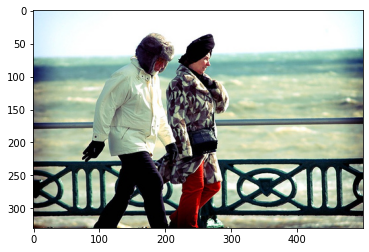

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('Flicker8k_Dataset/450596617_ed37ec0fe4.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# import threading

# threads = []
# x = 0
# y = 128

# n_threads = 10

# listrefs = [{} for _ in range(10)]
# listhypos = [{} for _ in range(10)]

# for i in range(n_threads):
#     threads.append(threading.Thread(target=generate_caption, args=(x,y,listrefs[i],listhypos[i])))
#     x += 128
#     y += 128

# for i in range(n_threads):
#     threads[i].start()

In [ ]:
# import threading

# threads = []
# x = 0
# y = 200

# n_threads = 8

# listrefs = [{} for _ in range(n_threads)]
# listhypos = [{} for _ in range(n_threads)]

# for i in range(n_threads):
#     threads.append(threading.Thread(target=generate_caption, args=(x,y,listrefs[i],listhypos[i])))
#     x += 200
#     y += 200

# for i in range(n_threads):
#     threads[i].start()

In [ ]:
# for i in range(n_threads):
#     threads[i].join()

In [ ]:
# generate_caption(1280,1529,ref1,hypo1):

In [ ]:
# valid_data['Flicker8k_Dataset/244910130_e1f823a28a.jpg']

In [ ]:
# ref = {}
# hypo = {}

# for i in range(n_threads):
#     ref.update(listrefs[i])
#     hypo.update(listhypos[i])

In [ ]:
# improveRef = {}
# for i,j in ref.items():
#     for k in j:
#         k = k.replace("<start> ", "")
#         k = k.replace(" <end>", "")
#         k = k.replace(" .", "")
#         if i in improveRef:
#             improveRef[i].append(k)
#         else:
#             improveRef[i] = [k]

In [ ]:
strRef = {}

for valid_image, caption in ref.items():
    strRef[valid_image] = [' '.join(x) for x in caption]
    
strRef

In [ ]:
strHypo = {}

for valid_image, caption in hypo.items():
    strHypo[valid_image] = [' '.join(caption[0])]
    
strHypo

## Bleu score using corpus_bleu

In [ ]:
# import pickle
# with open('ref.pickle', 'wb') as handle:
#     pickle.dump(ref, handle)

In [ ]:
# with open('hypo.pickle', 'wb') as handle:
#     pickle.dump(hypo, handle)

In [ ]:
# with open('ref.pickle', 'rb') as handle:
#     check_ref = pickle.load(handle)

In [ ]:
# with open('hypo.pickle', 'rb') as handle:
#     check_hypo = pickle.load(handle)

In [ ]:
# check_ref

In [ ]:
# check_hypo

In [ ]:
ref

In [ ]:
improveRef

{'Flicker8k_Dataset/632608471_a70461f123.jpg': ['A group of little girls perform a recital onstage dressed in all white',
  'Eleven girls in white tutus stand and pose onstage',
  'Group of ballerinas in white tutus get ready to dance',
  'The little ballerinas are all wearing white bows , dresses and leggings',
  'Young girl ballerinas in white tutus on a stage'],
 'Flicker8k_Dataset/3366904106_e996320d20.jpg': ['A boy in an orange shirt grinds a skateboard ramp',
  'a lone skateboarder wearing an orange shirt jumping on a ramp',
  'A skateboarder uses a ramp',
  'A young man in an orange shirt , maneuvers a skateboard at the top of a ramp',
  'Skateboarder on a ramp as seen through a chain link fence'],
 'Flicker8k_Dataset/3547524138_4157f660b0.jpg': ['Adults and children are playing with water balloons in the street',
  'A group of people play a game in the road',
  'A group of people play a game in the street , passing balloons to one another',
  'People passing water balloons in t

In [ ]:
hypo

{'Flicker8k_Dataset/632608471_a70461f123.jpg': ['a group of children are standing on a trampoline'],
 'Flicker8k_Dataset/3366904106_e996320d20.jpg': ['a young boy in a white shirt is standing on a fence'],
 'Flicker8k_Dataset/3547524138_4157f660b0.jpg': ['a girl in a pink dress is dancing'],
 'Flicker8k_Dataset/2264316030_600e55748d.jpg': ['a brown dog is running through the snow'],
 'Flicker8k_Dataset/424379231_23f1ade134.jpg': ['a dog jumps over a fence'],
 'Flicker8k_Dataset/78984436_ad96eaa802.jpg': ['a black and white dog is running on the grass'],
 'Flicker8k_Dataset/2369248869_0266760c4a.jpg': ['a black dog is running through the water'],
 'Flicker8k_Dataset/766346887_a9a9d0637a.jpg': ['a little boy is laying on a trampoline'],
 'Flicker8k_Dataset/2920305300_a5b1b2329a.jpg': ['a man wearing a red shirt is riding a bike'],
 'Flicker8k_Dataset/3272071680_648a99f7d2.jpg': ['a woman in a black shirt and a woman in a black shirt'],
 'Flicker8k_Dataset/3329858093_0ec73f2190.jpg': ['tw

In [ ]:
newRef = []
newHypo = []
for r in ref.values():
    newRef.append([i for i in r])

for h in hypo.values():
    newHypo.append(h[0])

In [ ]:
# [i.split() for i in h]

In [ ]:
len(newRef)

1552

In [ ]:
len(newHypo)

1552

In [ ]:
newHypo[0]

['a', 'man', 'and', 'a', 'woman', 'are', 'standing', 'on', 'the', 'beach', '.']

In [ ]:
newRef[0]

[['man', 'and', 'woman', 'walking', 'near', 'the', 'ocean', '.'],
 ['two',
  'people',
  'are',
  'walking',
  'alongside',
  'a',
  'decorative',
  'railing',
  'while',
  'wearing',
  'winter',
  'gear',
  '.'],
 ['two', 'people', 'are', 'walking', 'by', 'the', 'ocean', '.'],
 ['two', 'people', 'in', 'coats', 'walking', 'next', 'to', 'a', 'fence', '.'],
 ['two', 'people', 'walk', 'together', 'on', 'a', 'cold', 'day', '.']]

In [ ]:
newHypo

[['a',
  'man',
  'and',
  'a',
  'woman',
  'are',
  'standing',
  'on',
  'the',
  'beach',
  '.'],
 ['a',
  'young',
  'boy',
  'in',
  'a',
  'blue',
  'shirt',
  'is',
  'standing',
  'in',
  'the',
  'sand',
  '.'],
 ['a', 'black', 'dog', 'jumping', 'into', 'a', 'pool', '.'],
 ['a', 'group', 'of', 'people', 'are', 'in', 'a', 'field', '.'],
 ['a',
  'person',
  'is',
  'riding',
  'a',
  'snow',
  '##board',
  'through',
  'the',
  'air',
  '.'],
 ['a',
  'hockey',
  'player',
  'in',
  'a',
  'white',
  'uniform',
  'is',
  'playing',
  'hockey',
  '.'],
 ['a', 'skier', 'in', 'a', 'white', 'jacket', 'is', 'airborne', '.'],
 ['a',
  'little',
  'girl',
  'in',
  'a',
  'red',
  'jacket',
  'is',
  'climbing',
  'up',
  'a',
  'tree',
  '.'],
 ['a', 'black', 'dog', 'is', 'jumping', 'over', 'a', 'white', 'car', '.'],
 ['a',
  'boy',
  'in',
  'a',
  'red',
  'shirt',
  'and',
  'white',
  'shirt',
  'is',
  'sitting',
  'on',
  'a',
  'swing',
  '.'],
 ['a', 'dog', 'running', 'throu

In [ ]:
newRef

[[['man', 'and', 'woman', 'walking', 'near', 'the', 'ocean', '.'],
  ['two',
   'people',
   'are',
   'walking',
   'alongside',
   'a',
   'decorative',
   'railing',
   'while',
   'wearing',
   'winter',
   'gear',
   '.'],
  ['two', 'people', 'are', 'walking', 'by', 'the', 'ocean', '.'],
  ['two', 'people', 'in', 'coats', 'walking', 'next', 'to', 'a', 'fence', '.'],
  ['two', 'people', 'walk', 'together', 'on', 'a', 'cold', 'day', '.']],
 [['a',
   'boy',
   'looks',
   'startled',
   'as',
   'he',
   'falls',
   'in',
   'the',
   'sand',
   '.'],
  ['a',
   'boy',
   'recoil',
   '##s',
   'from',
   'the',
   'impact',
   'of',
   'sand',
   'onto',
   'his',
   'bare',
   'chest',
   '.'],
  ['a',
   'young',
   'boy',
   'falls',
   'back',
   'with',
   'his',
   'mouth',
   'open',
   'when',
   'sand',
   'is',
   'falling',
   'on',
   'him',
   '.'],
  ['a',
   'young',
   'boy',
   'getting',
   'some',
   'sand',
   'thrown',
   'on',
   'his',
   'chest',
   '.'],
  

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(newRef, newHypo, weights=(1, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(newRef, newHypo, weights=(0, 1, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(newRef, newHypo, weights=(0, 0, 1, 0)))
print('BLEU-4: %f' % corpus_bleu(newRef, newHypo, weights=(0, 0, 0, 1)))

BLEU-1: 0.636953
BLEU-2: 0.283438
BLEU-3: 0.128021
BLEU-4: 0.058423


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(newRef, newHypo, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(newRef, newHypo, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(newRef, newHypo, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(newRef, newHypo, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.636953
BLEU-2: 0.424896
BLEU-3: 0.322876
BLEU-4: 0.191694


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(ref, hypo, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(ref, hypo, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(ref, hypo, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(ref, hypo, weights=(0.25, 0.25, 0.25, 0.25)))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.626401
BLEU-2: 0.791455
BLEU-3: 0.869072
BLEU-4: 0.889638


In [ ]:
 # sample_caption_new = []
#         for i in sample_captions:
#             i = i.replace("<start>","")
#             i = i.replace(" <end>","").strip()
#             sample_caption_new.append(i)

#         print(sample_caption_new)
#         score = scorefunc(sample_caption_new, decoded_caption)
        
#         print("Score: ",score)
#         n+=1
#         if(n == 5): break